 # <font color=blue size=5><center> The propagation of Gaussian beams over a series of compound refractive lenses</center></font> 
##  Notes imported from HP Mathematical Code
CRLs can be composed arbitrarily as with Ch. Schroer' s CRLCalc, i.e. prescribe apex radius, apex thickness, aperture radius, number of elements, material and mass density. The optical parameters are calculated from this input. Lenses can be put into a beam in any order and their effect on the beam propagation is considered. This includes the reduction of waist due to absorption.
Details: Positions of intermediated foci is calculated for embedded Gaussian of source. Beam propagation is secion-wise, from source to lens, to lens etc to infinity. For each section propagation, we start with a real width. We transfer this to the embedded Gaussian width. Based on the position of the (ideal) waist, we layout the ideal beam envelope and switch back to the apparent beam. At each lens, the width is reduced according to beamshrinking, i.e. the waist size in the next section is increased. At each lens is also the on-axis transmission and the fukk transmission of the incident Gaussian beam calculated. From the reduction of photon number and beam envelope, the on-axis fluence can be calculated and thereby the beam profile. Finally, at each lens is its aperture for the exiting beam regarded, and set as additional radial constraint for the beam profile. However, the size and shape of foci is not re-considered, the hard-cut remains over the full propagation. We assume that clipping is not severe and preserve this assuption as condition for this script.
Please note that some positions of intermediated waist lead to imaginary numbers which are not treated correctly.

## PS By Lingen on 18.11, 2019: 
1. The function NewWaist is not used to calculate the final  new waist after transport. Instead, the functions BeamShrinking and EffectiveWaist are used to calculate the final new waist after transport. 
2. The function BeamShrinking is to calculate the shrink effect of the beam size due to the insert of CRL Lens. 
3. The function NewWaist is  used to calculate the intermediate new waist after transport, which will be used by the function NewWaistPosition. 
4. The function NewWaistPosition is to calculate the new waist position aftert the transport of XFEL beam in the CRL Lens.
5.  It seems Msquared is miss used in the script: for the original input beam, Msquared is used to calcuate the input and output radius curvatures and thus new waist position, while is not used for the waist size calculation.
6. Foci postion and size are very senstive to the postion of CRL Lens and refraction.

### <font color=#787878>Copyright</font>
<font color=#787878><i>The X-Ray transport through CRL lens is initially coded with Mathematica by HP, and then transferred to Python by Lingen & Qiqi. </i></font>

### Import Library

In [1]:
import math
from scipy.interpolate import interp1d
import pylab
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib import ticker
from math import sqrt
from math import pi

### Define function to calculate the new waist postion
Firstly, we define the function to calculate the position of new beam after transformation. The wavelength $\lambda$ of XFEL is defined as a global variable.<br> 
The Rayliegh length $x_r$ of the entering XFEL beam is:<br>
$$x_r = \frac{\pi {w_0}^2}{\lambda}$$
where $w_0$ is the beamwaist of entering XFEL beam.<br>
Thus, the entering beam width at the lens is:
$$w_1 = w_0\sqrt{1+{(\frac{x_0}{x_r})}^2}$$
The radius of curvature $R_0$ at the lens before transformation is:
$$R_0 =x_0(1+\frac{x_r}{x_0})$$
The radius of curvature $R_1$ at the lens after transformation is:
$$R_1 = \frac{R_0f}{f-R_0}$$
where $f$ is the focus length of the lens.<br>
The position of new beamwaist $bp$ exiting from the lens is:
$$bp = \frac{-R_1}{1+{(\frac{\lambda R_1}{\pi {w_1}^2})}^2}$$

In [2]:
def NewBPosition(w0,x0,f):
    global lambda_l
    x_r = pi*w0**2/lambda_l #Rayliegh length of the initial XFEL beam
    w1 = w0*sqrt(1+(x0/x_r)**2) #Beam width before the first lens
    R0 = x0*(1+(x_r/x0)**2) #Radius of curvature at the first lens, before transformation
    R1 = R0*f/(f-R0) #Radius of curvature at the first lens, after transformation
    bp = -R1/(1+(lambda_l*R1/pi/w1**2)**2)
    return bp

### Define function to calculate the intermediate new waist size
The position of new beamwaist $bw$ exiting from the lens is:
$$bw = w_1 \sqrt{\frac{1}{1+{(\frac{\pi {w_1}^2}{\lambda R_1})}^2}}$$

In [3]:
def NewBWaist(w0,x0,f):
    global lambda_l
    x_r = pi*w0**2/lambda_l #Rayliegh length of the initial XFEL beam
    w1 = w0*sqrt(1+(x0/x_r)**2) #Beam width before the first lens
    R0 = x0*(1+(x_r/x0)**2) #Radius of curvature at the first lens, before transformation
    R1 = R0*f/(f-R0) #Radius of curvature at the first lens, after transformation
    bw = w1*sqrt(1/(1+(pi*w1**2/lambda_l/R1)**2))
    return bw

### Define XFEL Parameters 
<i>Beam waist $w_0$, Photon energy $E_{XFEL}$ in keV, Wavelength $\lambda = \frac{12.408}{E_{XFEL}}\times 10^{-10}m$, Divergence angle $\theta_0$ in rad and $M^2$ </i> <br>
The beam parameter product is $M^2 = \frac{\pi w_0 \theta_0}{\lambda}$.<br>
The new waist for the almost-Gaussian beam is $w_0 = \frac{w_0}{M}$.<br>

In [4]:
w0 = 40e-6 # in unit of m
E_XFEL = 6.457 # XFEL Photon energy in KeV
lambda_l = 12.408/E_XFEL*1e-10 # XFEL energy in meter
theta0  =  2.0*1e-6 # source divergence in rad 
Msquared = pi*w0*theta0/lambda_l
#Msquared = 1
w0 = w0/sqrt(Msquared) # in unit of m

### Define CRL Parameters
<i>Eight elements:
    Position, Number of elements, Apex radius, Aperture radius, Apex thickness, Material index, Mass density in g/cc and atomic relative mass</i> <br>
    <i>Note: the position of the lens is set relatively to the position of the entering beam waist. </i>

In [5]:
#---Lens Input Parameters----------#
#---Position, Number of elements, Apex radius, Aperture radius, Apex thickness, Material index, Mass density in g/cc, atomic mass
LensA = np.array([230, 1, 3700*1e-6, 1000*1e-4, 100*1e-6, 4, 1.845, 9.0122])
LensB1 = np.array([52.63, 9, 300*1e-6, 500*1e-5, 30*1e-6, 4, 1.845,9.0122])
#LensB2 = np.array([2.075, 9, 300*1e-6, 500*1e-5, 30*1e-6, 4, 1.845,9.0122])
LensB2 = np.array([5.075, 9, 300*1e-6, 500*1e-5, 30*1e-6, 4, 1.845,9.0122])
Lenses = np.stack((LensA, LensB1, LensB2))

x0 = Lenses[0,0] #The distance between first beam waist position and first lens
x2 = Lenses[1,0] #The distance between second beam waist position and second lens
x4 = Lenses[2,0] #The distance between third beam waist position and third len

Be = np.array([1.85, 4, 9.0122]) # Beryllium rho,Z atomic number,atomic mass A
Carbon = np.array([1.5, 6, 12]) # Glassy Carbon rho,Z atomic number,atomic mass A
Be_exp = np.loadtxt("Be.dat")
Be_exp[:,1]=Be_exp[:,1]*LensA[6] # \delta 
Be_exp[:,2]=Be_exp[:,2]*LensA[6]*100 # \mu in m^-1

### Calculate the Refraction and  Focus length for each CRL lens
<font size=2.5> Refraction $\delta$ formular:</font>
$$\delta = 2.7\times10^{-6}(\lambda^2\rho Z/A)$$
<br>where the units of $\lambda$, $\rho$ are Angstrom and g/cc respectively. Z and A are atomic number and relative mass respectively. </br>
<br><font size=2.5> Focus length formular:</font></br>
$$f = \frac{R}{2N\delta}$$
where <i>R</i> and <i>N</i> are the apex curvature and number of elements of CRL lens respectively. 

In [6]:
# delta and mu of CRL lens versus photon energy array
Photon_Energy = np.linspace(0.5,24,100) # Photon Energy in keV
Photon_Lambda = 12.408/Photon_Energy # X-Ray Wavelength in Angstrom
Photon_delta_Be = 2.7*1e-6*Photon_Lambda**2*Lenses[0,6]*Lenses[0,5]/Lenses[0,7] # refraction
#Photon_delta_Be = 2.7*1e-6*Photon_Lambda**2*Lenses[0,6]*(Lenses[0,5]+1)/Lenses[0,7] # refraction
Photon_delta_C = 2.7*1e-6*Photon_Lambda**2*Carbon[0]*Carbon[1]/Carbon[2] # refraction
Photon_mu_Be = 1.003*1e5*Photon_Energy**(-2.889) #fitting attenuation length in m^-1
f_Mu = interp1d(Be_exp[:,0], Be_exp[:,2], kind='cubic') #Cubic interpolation attenuation length in m^-1
Photon_mu_Be_itp = f_Mu(Photon_Energy*1e3) #Cubic interpolation attenuation length in m^-1
f1_Be = Lenses[0,2]/2/Lenses[0,1]/Photon_delta_Be
f1_C = Lenses[0,2]/2/Lenses[0,1]/Photon_delta_C

# delta and mu of CRL lens versus single photon energy
delta_Be = 2.7*1e-6*(lambda_l*1e10)**2*Lenses[0,6]*Lenses[0,5]/Lenses[0,7] # refraction
#delta_Be = 2.7*1e-6*(lambda_l*1e10)**2*Lenses[0,6]*(Lenses[0,5]+1)/Lenses[0,7] # refraction
delta_C = 2.7*1e-6*(lambda_l*1e10)**2*Carbon[0]*Carbon[1]/Carbon[2] # refraction
mu_Be = 1.003*1e5*E_XFEL**(-2.889) #fitting attenuation length in m^-1
MuValue = f_Mu(E_XFEL*1e3) #Cubic interpolation attenuation length in m^-1
MuValue_itp_linear = np.interp(E_XFEL*1e3,Be_exp[:,0], Be_exp[:,2]) # Linear interpolation attenuation length in m^-1
MuValue_M = 347.865 # interpolation attenuation length in m^-1 from Mathematica


f1 = Lenses[0,2]/2/Lenses[0,1]/delta_Be # Focus length from theoretic delta_Be
f2 = Lenses[1,2]/2/Lenses[1,1]/delta_Be # Focus length from theoretic delta_Be
f3 = Lenses[2,2]/2/Lenses[2,1]/delta_Be # Focus length from theoretic delta_Be
f1_itp = 226.291 # Focus length from interpolation delta_Be
f2_itp = 2.03866 # Focus length from interpolation delta_Be
f3_itp = 2.03886 # Focus length from interpolation delta_Be
#f1 = f1_itp
#f2 = f2_itp
#f3 = f3_itp

In [7]:
print(mu_Be,MuValue,MuValue_M,MuValue_itp_linear) 
print(f1,f2,f3) 
print(f1_itp,f2_itp,f3_itp) 

458.27059449809275 347.8599336820605 347.865 349.04777148000005
226.58983684443118 2.0413498814813615 2.0413498814813615
226.291 2.03866 2.03886


### Calculate the new waist position and intermediate waist size

In [8]:
# x0=Lenses(1,1) #The distance between first beam waist position and first lens

w1 = NewBWaist(w0, x0, f1) #First new beamwaist after transformed by the first lens
x1 = NewBPosition(w0, x0, f1) #Distance between the first lens and the position of the first new beamwaist

#x2 = Lenses(2,1)-x0-x1 #The distance between second beam waist position and second lens

w2 = NewBWaist(w1, x2, f2) #Second new beamwaist after transformed by the second lens
x3 = NewBPosition(w1, x2, f2) #Distance between the second lens and the position of the second new beamwaist

#x4 = Lenses(3,1)-x0-x1-x2-x3 #The distance between third beam waist position and third lens

w3 = NewBWaist(w2, x4, f3) #Second new beamwaist after transformed by the second lens
x5 = NewBPosition(w2, x4, f3) #Distance between the second lens and the position of the second new beamwaist

x_sum = x0+x1+x2+x3+x4+x5 #Distance between  the beam source and the position of the second new beamwaist 

In [9]:
print (x1,x3,x5)
print (w1*1e6,w2*1e6,w3*1e6)

651.9431527809644 2.0413837425065244 3.414978320290689
390.6275710548699 0.31958500864290723 0.21504942732641044


### Calculate the initial beam envelope and transmission function 

In [10]:
z0 = np.linspace(0,x0,100) # Domain of the initial XFEL beam
w0 = w0*sqrt(Msquared) # in unit of m
x_r0 = pi*w0**2/lambda_l# Rayliegh length of the initial XFEL beam
w_z0 = w0*np.sqrt(1+(z0/x_r0)**2) # Beam Envelope of the initial XFEL beam
T0 = np.ones(len(z0))

### Calculate the beam envelope and transmission function after first CRL lens
 New beam width at lens after transmission will be shrinked due to the insert of CRL lens, the beam width exiting from the lens $w^\ast$ will be:<br>
<br>$$w^\ast =w_{z0}\sqrt{\frac{2R}{2R+N\mu {w_{z0}}^2}}$$<br>
The new effective beam waist $w_1$ after first lens is (<i>How is this formula derived?</i>):
<br>$$w_1 = \sqrt{\frac{{w^\ast}^2}{2}-\sqrt{\frac{\pi^2 {w^\ast}^4-{(2\lambda x_1)}^2}{2\pi}}}$$<br>
The Rayliegh length $x_{R1}$ of the new beam after first lens is:
<br>$$x_{r1} = \frac{\pi {w_1}^2}{\lambda}$$<br>
 Beam envelope of new beam $w_{z1}$ after first lens is:
$$w_{z1} = w_1\sqrt{1+{(\frac{z_1-x_0-x_1}{x_{r1}})}^2}$$

<br> The transmission after the first lens $T_1$ can be calculate by:<br>
$$T_1 = exp(-N\mu d_0){(\frac{w^\ast}{w_{z0}})}^2$$

In [11]:
z1 = np.linspace(x0,x0+x1+x2,200)  # Domain of the first beam after first lens
BeamShrinking1 =  np.sqrt(2*Lenses[0,2]/(2*Lenses[0,2] + Lenses[0,1]*MuValue*w_z0[-1]**2)) 
StartWidth1 = w_z0[-1]*BeamShrinking1 
w1 = np.sqrt(StartWidth1**2/2-np.sqrt(pi**2*StartWidth1**4-(2*lambda_l*x1)**2)/2/pi)  
x_r1 = pi*w1**2/lambda_l # Rayliegh length of the first beam after first lens
w_z1 = w1*np.sqrt(1+((z1-x0-x1)/x_r1)**2)  # Beam Envelope of first beam after first lens
T1 = T0[1]*np.exp(-Lenses[0,1]*MuValue*Lenses[0,4])*BeamShrinking1**2*np.ones(len(z1))

### Calculate the beam envelope and transmission function after second CRL lens

In [12]:
z2 = np.linspace(x0+x1+x2,x0+x1+x2+x3+x4,200)  # Domain of the second beam after second lens
BeamShrinking2 =  np.sqrt(2*Lenses[1,2]/(2*Lenses[1,2] + Lenses[1,1]*MuValue*w_z1[-1]**2)) 
StartWidth2 = w_z1[-1]*BeamShrinking2   
w2 = np.sqrt(StartWidth2**2/2-np.sqrt(pi**2*StartWidth2**4-(2*lambda_l*x3)**2)/2/pi)  
x_r2 = pi*w2**2/lambda_l # Rayliegh length of the second beam after second lens
w_z2 = w2*np.sqrt(1+((z2-x0-x1-x2-x3)/x_r2)**2)  # Beam Envelope of second beam after second lens
T2 = T1[1]*np.exp(-Lenses[1,1]*MuValue*Lenses[1,4])*BeamShrinking2**2*np.ones(len(z2))

### Calculate the beam envelope and transmission function after third CRL lens

In [13]:
z3 = np.linspace(x0+x1+x2+x3+x4,1.01*x_sum,200)  # Domain of the third beam after third lens
BeamShrinking3 =  np.sqrt(2*Lenses[2,2]/(2*Lenses[2,2] + Lenses[2,1]*MuValue*w_z2[-1]**2)) 
StartWidth3 = w_z2[-1]*BeamShrinking3  
w3 = np.sqrt(StartWidth3**2/2-np.sqrt(pi**2*StartWidth3**4-(2*lambda_l*x5)**2)/2/pi)  
x_r3 = pi*w3**2/lambda_l # Rayliegh length of the third beam after third lens
w_z3 = w3*np.sqrt(1+((z3-x_sum)/x_r3)**2)  # Beam Envelope of third beam after third lens
T3 = T2[1]*np.exp(-Lenses[2,1]*MuValue*Lenses[2,4])*BeamShrinking3**2*np.ones(len(z3))

### Stack the arrays

In [14]:
z = np.concatenate((z0,z1, z2, z3))
w_z = np.concatenate((w_z0, w_z1, w_z2, w_z3))
T_z  = np.concatenate((T0, T1, T2, T3))

### Plot Figures

230.0 881.9431527809644 934.5731527809644 936.6145365234709 941.6895365234709 945.1045148437616


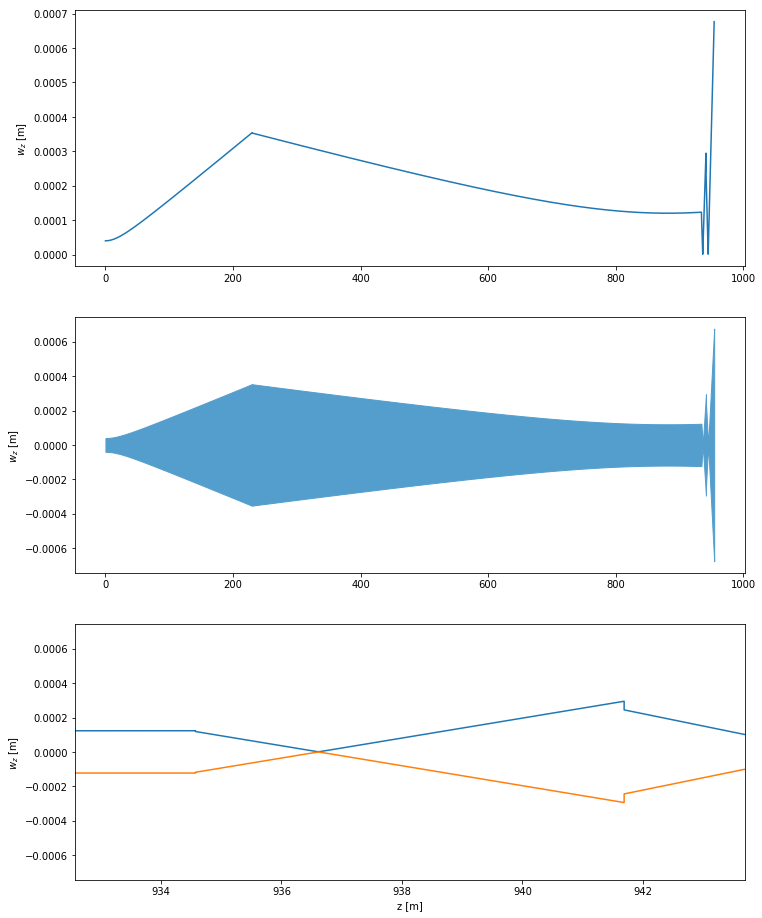

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(12, 16)
ax1=plt.subplot(3, 1, 1)
ax1.plot(z, w_z)
plt.ylabel("$w_z$ [m]")
ax2=plt.subplot(3, 1, 2)
plt.fill_between(z, w_z, -w_z,color='#539ecd')
#ax2.set_yscale('log')
#ax2.set_ylim([50e-6, 1e-3])
plt.ylabel("$w_z$ [m]")
ax3=plt.subplot(3, 1, 3)
ax3.plot(z, w_z,z,-w_z)
ax3.set_xlim([x0 + x1 + x2 -2, x0 + x1 +x2 +x3+ x4+2])
#ax3.set_ylim([-1.5e-4, 1.5e-4])
plt.xlabel("z [m]")
plt.ylabel("$w_z$ [m]")
print (x0, x0 + x1, x0 + x1 + x2, x0 + x1 +x2 + x3,x0 + x1 +x2 +x3+ x4, x0 + x1 + x2 + x3 + x4+x5)
plt.show()

Text(0, 0.5, '$w_z$ [m]')

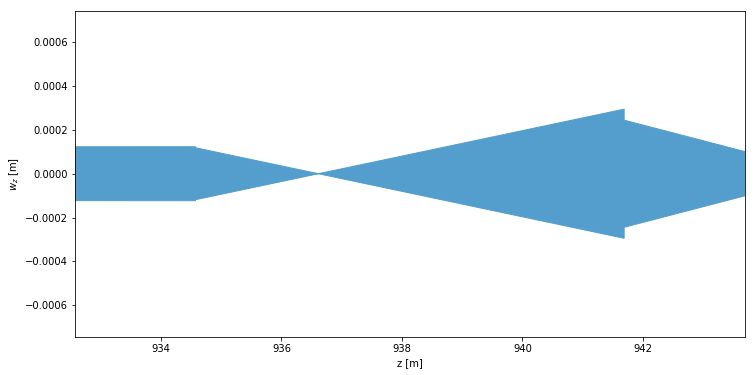

In [16]:
plt.figure(figsize=(12, 6))
plt.fill_between(z, w_z, -w_z,color='#539ecd')
plt.xlim(x0 + x1 + x2 -2, x0 + x1 +x2 +x3+ x4+2)
plt.xlabel("z [m]")
plt.ylabel("$w_z$ [m]")
#plt.yscale('log')
#plt.savefig('TestTransport.png', bbox_inches='tight')

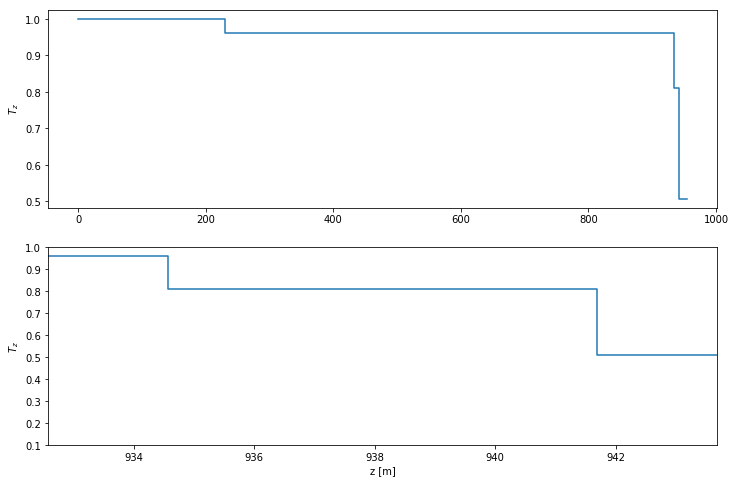

In [17]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(12, 8)
ax1=plt.subplot(2, 1, 1)
ax1.plot(z, T_z)
plt.ylabel("$T_z$")
ax2=plt.subplot(2, 1, 2)
ax2.plot(z, T_z)
ax2.set_xlim([x0 + x1 + x2 -2, x0 + x1 +x2 +x3+ x4+2])
ax2.set_ylim([0.1, 1])
plt.xlabel("z [m]")
plt.ylabel("$T_z$")
plt.show()

In [18]:
Be_exp.shape

(864, 3)

<function matplotlib.pyplot.show(*args, **kw)>

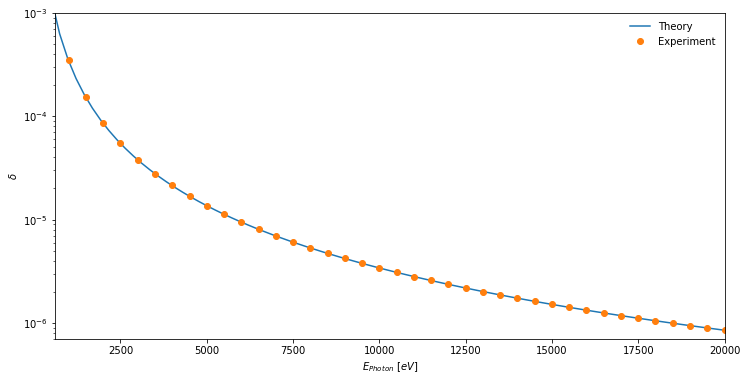

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(Photon_Energy*1000,Photon_delta_Be,Be_exp[:,0], Be_exp[:,1],"o")
plt.xlim(600, 20000)
plt.ylim(7e-7, 1e-3)
plt.yscale('log')
plt.xlabel("$E_{Photon}\ [eV]$")
plt.ylabel("$\delta$")
plt.legend(["Theory", "Experiment"],frameon=False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

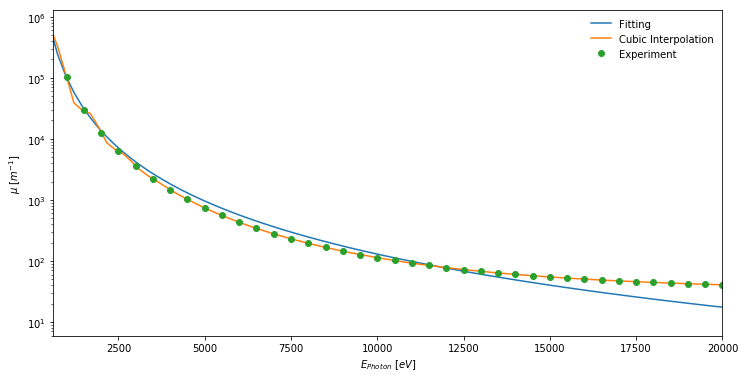

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(Photon_Energy*1000,Photon_mu_Be,Photon_Energy*1000,Photon_mu_Be_itp,Be_exp[:,0], Be_exp[:,2],"o")
plt.xlim(600, 20000)
#plt.ylim(0, 600)
plt.yscale('log')
plt.xlabel("$E_{Photon}\ [eV]$")
plt.ylabel("$\mu \ [m^{-1}]$")
plt.legend(["Fitting","Cubic Interpolation", "Experiment"],frameon=False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

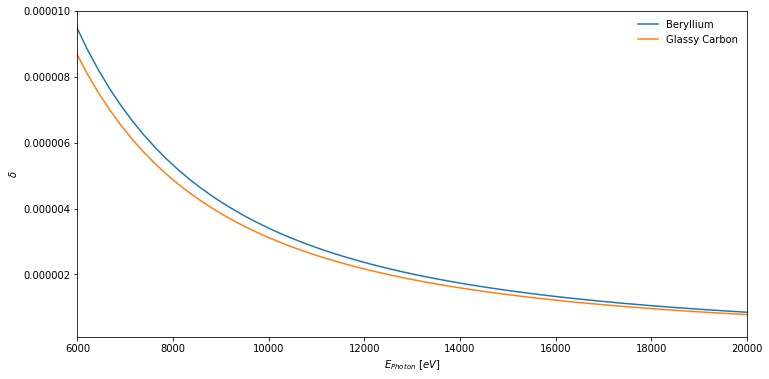

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(Photon_Energy*1000,Photon_delta_Be,Photon_Energy*1000,Photon_delta_C)
plt.xlim(6000, 20000)
plt.ylim(1e-7, 1e-5)
#plt.yscale('log')
plt.xlabel("$E_{Photon}\ [eV]$")
plt.ylabel("$\delta$")
plt.legend(["Beryllium", "Glassy Carbon"],frameon=False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

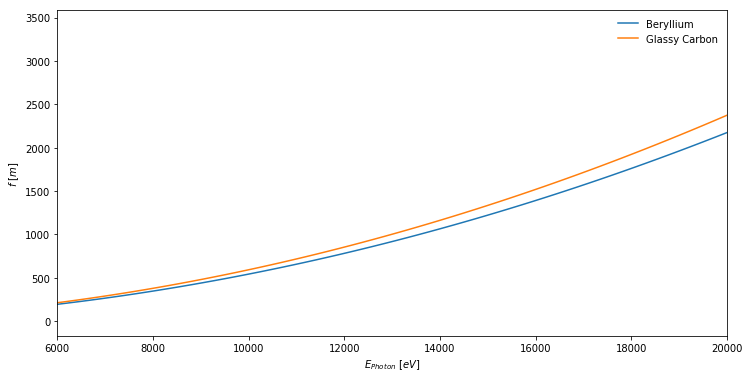

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(Photon_Energy*1000,f1_Be,Photon_Energy*1000,f1_C)
plt.xlim(6000, 20000)
#plt.ylim(1e-7, 1e-5)
#plt.yscale('log')
plt.xlabel("$E_{Photon}\ [eV]$")
plt.ylabel("$f\ [m]$")
plt.legend(["Beryllium", "Glassy Carbon"],frameon=False)
plt.show

In [23]:
 w3 = np.sqrt(StartWidth3**2/2-np.sqrt(pi**2*StartWidth3**4-(2*lambda_l*x5)**2)/2/pi)  


In [24]:
w3

8.545877501187745e-07

In [25]:
delta_Be = 2.7*1e-6*(lambda_l*1e10)**2*Lenses[0,6]*Lenses[0,5]/Lenses[0,7] # refraction

In [26]:
delta_Be

8.16453211566654e-06

In [27]:
delta_Be = 2.7*1e-6*(lambda_l*1e10)**2*Lenses[0,6]*(Lenses[0,5]+1)/Lenses[0,7] # refraction

In [28]:
delta_Be

1.0205665144583175e-05

In [29]:
Lenses[0,5]

4.0